Задача по распознаванию позитивных и негативных отзывы людей по автомобилю Tesla.

**Импорт библиотек, загрузка базы и подготовка её к предобработке.**

In [ ]:
# Работа с массивами данных
import numpy as np
# Работа с таблицами
import pandas as pd
# Отрисовка графиков
import matplotlib.pyplot as plt
# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils
# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential
# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer
# Заполнение последовательностей до определенной длины
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Загрузка датасетов из облака google
import gdown
# Для работы с файлами в Colaboratory
import os
# Отрисовка графиков
import matplotlib.pyplot as plt

In [ ]:
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l7/tesla.zip', None, quiet=True)

'tesla.zip'

**Деление общей базы отзывов на данные для обучения и проверки.**

In [ ]:
# Распаковка архива в папку writers
!unzip -qo tesla.zip -d tesla/

# Просмотр содержимого папки
!ls tesla

'Негативный отзыв.txt'	'Позитивный отзыв.txt'


**Загрузка текста из файлов, преобразование в одну строку.**

In [ ]:
# Объявляем функции для чтения файла. На вход отправляем путь к файлу
def read_text(file_name):

  # Задаем открытие нужного файла в режиме чтения
  read_file = open(file_name, 'r')

  # Читаем текст
  text = read_file.read()

  # Переносы строки переводим в пробелы
  text = text.replace("\n", " ")

  # Возвращаем текст файла
  return text

# Объявляем интересующие нас классы
class_names = ["Негативный отзыв", "Позитивный отзыв"]

# Считаем количество классов
num_classes = len(class_names)

**Тексты в один список.**

In [ ]:
import os
# Создаём список под тексты для обучающей выборки
texts_list = []

# Циклом проводим итерацию по текстовым файлам в папке отзывов
for j in os.listdir('/content/tesla/'):

  # Добавляем каждый файл в общий список для выборки
        texts_list.append(read_text('/content/tesla/' + j))

        # Выводим на экран сообщение о добавлении файла
        print(j, 'добавлен в обучающую выборку')

Позитивный отзыв.txt добавлен в обучающую выборку
Негативный отзыв.txt добавлен в обучающую выборку


In [ ]:
# Узнаем объём каждого текста в символах
texts_len = [len(text) for text in texts_list]

# Устанавливаем "счётчик" номера текста
t_num = 0

# Выводим на экран  информационное сообщение
print(f'Размеры текстов по порядку (в символах):')

# Циклом проводим итерацию по списку с объёмами текстов
for text_len in texts_len:

  # Запускаем "счётчик" номера текста
  t_num += 1

  # Выводим на экран сообщение о номере и объёме текста
  print(f'Текст №{t_num}: {text_len}')

Размеры текстов по порядку (в символах):
Текст №1: 213381
Текст №2: 134535


Далее рассчитаем, сколько символов составит 80% объёма каждого текста, чтобы по полученному индексу отделить эти 80% на обучающую и оставшиеся 20% на проверочную выборку. Эти значения необходимы для подготовки деления на выборки слайсингом по индексу.

In [ ]:
# Создаём список с вложенным циклом по длинам текстов, где i - 100% текста, i/5 - 20% текста
train_len_shares = [(i - round(i/5)) for i in texts_len]

# Устанавливаем "счётчик" номера текста
t_num = 0

# Циклом проводим итерацию по списку с объёмами текстов равными 80% от исходных
for train_len_share in train_len_shares:

  # Запускаем "счётчик" номера текста
  t_num += 1

  # Выводим на экран сообщение о номере и объёме текста в 80% от исходного
  print(f'Доля 80% от текста №{t_num}: {train_len_share} символов')

Доля 80% от текста №1: 170705 символов
Доля 80% от текста №2: 107628 символов


In [ ]:
from itertools import chain

# Создадим пустой список для обучающей выборки
train_data = []

# Поделим тексты по индексу
train_data = list(chain(train_data, (texts_list[0][:170705], texts_list[1][:107628])))

# Убедимся, что кол-во классов и типы данных всё те же
print(len(train_data))
print(type(train_data))
print(type(train_data[0]))

2
<class 'list'>
<class 'str'>


In [ ]:
# Создадим пустой список для обучающей выборки
test_data = []

# Поделим тексты по индексу
test_data = list(chain(test_data, (texts_list[0][170705:], texts_list[1][107628:])))

# Убедимся, что кол-во классов и типы данных всё те же
print(len(test_data))
print(type(test_data))
print(type(test_data[0]))

2
<class 'list'>
<class 'str'>


Обрабатываем текстовые данные Tokenizer'ом:

In [ ]:
# Максимальное количество слов
maxWordsCount = 10000

# Сохраним Токенайзер в одноименной переменной
tokenizer = Tokenizer(num_words=maxWordsCount,                                        # Максимальное кол-во слов
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',  # Фильтры исходного текста
                      lower=True, split=' ',                                          # Все буквы к нижнему регистру, разделение слов пробелом
                      oov_token='unknown',                                            # Один лейбл для всех незнакомых слов
                      char_level=False)                                               # Без выравнивания символов

# Создание словаря частотности по каждой выборке
tokenizer.fit_on_texts(train_data)
tokenizer.fit_on_texts(test_data)

In [ ]:
train_data[0]

' Водитель наслаждается от такого авто и вождения  Красивая машина нужно брать  Тесла топ, тащусь от этой тачки Плюсы - зарядка бесплатная.\xa0 Машина топ Технологии по автоматизации не стоят на месте! Красивая машина нужно брать  Хочу радоваться езде на своей тесле!\xa0  Это вам не приора\xa0  Автомобиль - мечта!!!\xa0  Эта машина моя мечта  Тесла это гаджет, который нет смысла покупать? Сотни тысяч людей уже нашли смысл купить) Ну наконец любители трона объявились) а то будто я один от него фанатею  , как раз таки на этой машине он всё сделал так, как будто оно было с завода. С таким интерьером прям очень хорошо смотрится. Напоминает подсветку, как на каком-нибудь мерседесе. А пацанские девяточки здесь и рядом не стоят, потому что с их древним салоном сразу видно, что никакой подсветки там никогда не было и её тупо вколхозили.  Образно говоря - мой IPS дисплей на ноутбуке со светодиодной подсветкой и разрешением 2048*1536 точек с соотношением сторон 4:3 настолько офуительно хорош, чт

И переводим полученный словарь частотности в последовательность индексов:

In [ ]:
train_sequence = tokenizer.texts_to_sequences(train_data)
test_sequence = tokenizer.texts_to_sequences(test_data)

In [ ]:
# Посмотрим первые 15 индексов частоты слов oбучающей и тестовой выборок
print(len(train_sequence[0]))
print(len(test_sequence[0]))
print(train_sequence[0][:15])
print(test_sequence[0][:15])

25769
6591
[933, 4570, 28, 261, 29, 2, 934, 249, 14, 83, 262, 9, 328, 4571, 28]
[2806, 430, 14, 193, 2003, 1091, 86, 6, 83, 6, 847, 37, 94, 2004, 223]


Далее создаём функцию деления выборки на примеры скользящим окном:

In [ ]:
def split_sequence(sequence,   # Последовательность индексов
                   win_size,   # Размер окна для деления на примеры
                   hop):       # Шаг окна

    # Последовательность разбивается на части до последнего полного окна
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]

Основная функцию для формирования окончательного вида выборок и создание меток классов:

In [ ]:
def get_samples(seq_list,    # Список последовательностей индексов
                       win_size,    # Размер окна для деления на примеры
                       hop):        # Шаг окна

    # В списке последовательности следуют в порядке их классов (их кол-во сповпадает с кол-вом классов)
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):

        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)

        # Добавление отрезков в выборку

        x += vectors

        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [cls] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)

Используя вышенаписанные функции, поделим базу индексов на множество примеров и соберём выборки:

In [ ]:
# Длина каждого отрезка индексов
sample_len = 100

# Длина шага по исходному массиву индексов
step = 10

# Делим на выборки
x_train, y_train = get_samples(train_sequence, sample_len, step)
x_test, y_test = get_samples(test_sequence, sample_len, step)

In [ ]:
# Выведем размерности всех выборок
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4250, 100)
(4250,)
(1074, 100)
(1074,)


Создаём выборки из последовательности индексов в матрицы из 0 и 1 для **Bag of Words**:

In [ ]:
# Выборка для обучения
x_train_BoW = tokenizer.sequences_to_matrix(x_train.tolist())

# Выборка для проверки
x_test_BoW = tokenizer.sequences_to_matrix(x_test.tolist())

Создаём линейную модель сети для обучения на **Bag OF Words**:

In [ ]:
modelBoW = Sequential()                                    # Создаём полносвязную сеть для обучения на Bag of Words
modelBoW.add(BatchNormalization(input_dim=maxWordsCount))  # Слой пакетной нормализации
modelBoW.add(Dense(32, activation="relu"))                  # Полносвязный слой
modelBoW.add(Dropout(0.4))                                 # Слой регуляризации Dropout
modelBoW.add(Dense(1, activation='sigmoid'))               # Выходной полносвязный слой

modelBoW.compile(optimizer='adam',                         # Компиляция модели
              loss='binary_crossentropy',
              metrics=['accuracy'])
modelBoW.summary()                                         # Обобщение информации по модели

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_13 (Bat  (None, 10000)            40000     
 chNormalization)                                                
                                                                 
 dense_28 (Dense)            (None, 32)                320032    
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 360,065
Trainable params: 340,065
Non-trainable params: 20,000
_________________________________________________________________


 Запускаем обучение сети на **Bag of Words** с соответствующими параметрами:

Epoch 1/20
34/34 [==============================] - 1s 12ms/step - loss: 0.1917 - accuracy: 0.9158 - val_loss: 0.5826 - val_accuracy: 0.6108
Epoch 2/20
34/34 [==============================] - 0s 7ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.6165 - val_accuracy: 0.6127
Epoch 3/20
34/34 [==============================] - 0s 7ms/step - loss: 0.0035 - accuracy: 0.9998 - val_loss: 0.6517 - val_accuracy: 0.6164
Epoch 4/20
34/34 [==============================] - 0s 6ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.6749 - val_accuracy: 0.6276
Epoch 5/20
34/34 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.7413 - val_accuracy: 0.6304
Epoch 6/20
34/34 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.6611 - val_accuracy: 0.6778
Epoch 7/20
34/34 [==============================] - 0s 7ms/step - loss: 9.4916e-04 - accuracy: 1.0000 - val_loss: 0.6711 - val_accuracy: 0.6918
Epoch 8/20
34/3

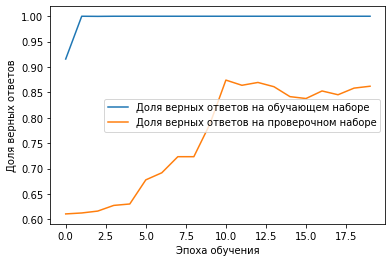

In [ ]:
# Обучение сети Bag of Words
history = modelBoW.fit(x_train_BoW,
                      y_train,
                      epochs=20,
                      batch_size=128,
                      validation_data=(x_test_BoW, y_test))

# Отрисовка графика точностей обучения по эпохам
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()